# 라이브러리 호출

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import LearningRateScheduler


In [2]:

# GPU 사용 여부 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,  
    shuffle_files=True, 
    with_info=True,
)

#### 에러 해결
기존 코드로 진행했을 경우, dict 형태로 받아 에러가 났지만, 이를 해결하기 위해 `as_supervised=True`를 사용해 튜플 형태로 받는다. 

In [18]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


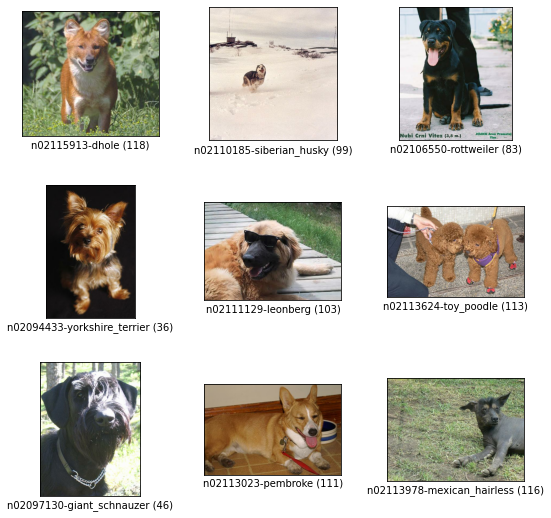

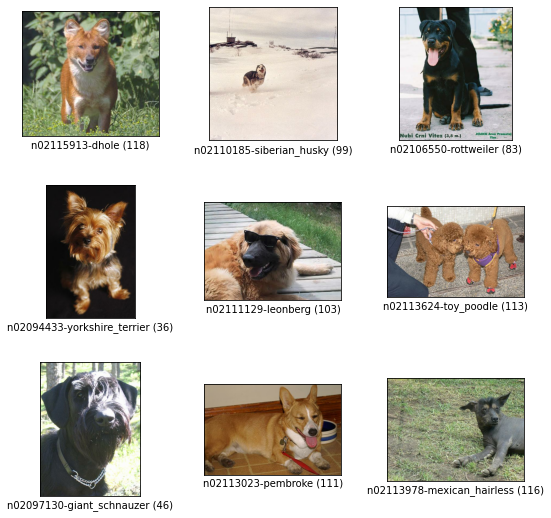

In [19]:
tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [20]:
# 이미지 사이즈 조정 및 정규화
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [21]:
# 기본 Augmentation 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# Augmentation2 함수 (추가 증강)
def augment2(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    random_rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=random_rotations)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    if image.shape[-1] == 3:
        image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    image = image + noise
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [22]:
# 라벨 원-핫 인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

#### Cutmix

In [23]:
# CutMix 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [24]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup

In [25]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [26]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 전처리 적용

In [27]:
# 데이터셋 전처리 및 증강 적용
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_classes = ds_info.features["label"].num_classes

def apply_normalize_on_dataset(
    ds, 
    is_test=False, 
    batch_size=16, 
    with_aug=False, 
    with_cutmix=False,
    with_mixup=False,
#     aug_func=augment
):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ## test 데이터가 아니면서 aug를 할 데이터 셋
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    
    ## test 데이터가 아니면서 cutmix 할 데이터 셋
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    ## test 데이터가 아니면서 mixup 할 데이터 셋
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
## No Augmentation
ds_train_original = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False
)

## 기본 Augmentation
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False,
    with_mixup=False,
)

# ## 기본 Augmentation2
# ds_train_aug2 = apply_normalize_on_dataset(
#     ds_train,
#     is_test=False, 
#     with_aug=True,
#     with_cutmix=False, 
#     with_mixup=False,
#     aug_func=augment2
# )

## CutMix만 적용
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=True, 
    with_mixup=False    
)

## 기본 Augmentation + CutMix 적용
ds_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=True,
    with_mixup=False
)

## Mixup만 적용
ds_train_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False,
    with_mixup=True    
)

## 기본 Augmentation + Mixup 적용
ds_train_aug_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False, 
    with_mixup=True
)

## test 셋에 대한 전처리
ds_test = apply_normalize_on_dataset(
    ds_test,
    is_test=True, 
    with_aug=False,
    with_cutmix=False
)

## 2. 모델 만들기

In [31]:

import os




# 체크포인트 저장 경로 설정
checkpoint_path = "checkpoints/base-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 정의
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # 모델 가중치만 저장
    save_best_only=True,       # 검증 손실이 가장 낮을 때만 저장
    monitor='val_loss',        # 검증 손실 기준
    mode='min',                # 검증 손실이 가장 낮을 때 저장
    save_freq='epoch',         # 매 epoch 마다 저장
    verbose=1                  # 저장 시 메시지 출력
)


# 모델 정의
def create_model(num_classes):
    return keras.models.Sequential([
        keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

# 모델 컴파일 및 학습 함수
def compile_and_train(model, train_data, test_data, epochs, callbacks):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    return model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
        validation_steps=int(ds_info.splits['test'].num_examples / 16),
        verbose=1,
        callbacks=callbacks
    )


# 학습을 위한 모델 생성 및 학습 수행
EPOCHS = 20

## 3. 모델 훈련하기

In [32]:
for images, labels in ds_train_original.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [33]:
for images, labels in ds_test.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [34]:
# 모델별 학습 수행
resnet50_original = create_model(num_classes)
history_original = compile_and_train(resnet50_original, ds_train_original, ds_test, EPOCHS, [checkpoint_callback])

Epoch 1/20
750/750 [==============================] - 169s 209ms/step - loss: 4.8155 - accuracy: 0.0125 - val_loss: 4.9152 - val_accuracy: 0.0148

Epoch 00001: val_loss improved from inf to 4.91520, saving model to checkpoints/base-cp-0001.ckpt
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 4.5188 - accuracy: 0.0282 - val_loss: 5.1618 - val_accuracy: 0.0171

Epoch 00002: val_loss did not improve from 4.91520
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 4.1453 - accuracy: 0.0590 - val_loss: 4.0227 - val_accuracy: 0.0697

Epoch 00003: val_loss improved from 4.91520 to 4.02268, saving model to checkpoints/base-cp-0003.ckpt
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 3.7654 - accuracy: 0.1041 - val_loss: 4.1518 - val_accuracy: 0.0770

Epoch 00004: val_loss did not improve from 4.02268
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 3.3784 - accuracy: 0.1622 - val_

In [ ]:
resnet50_aug = create_model(num_classes)
history_aug = compile_and_train(resnet50_aug, ds_train_aug, ds_test, EPOCHS, [checkpoint_callback])

In [ ]:
resnet50_cutmix = create_model(num_classes)
history_cutmix = compile_and_train(resnet50_cutmix, ds_train_cutmix, ds_test, EPOCHS, [checkpoint_callback])

In [ ]:
resnet50_aug_cutmix = create_model(num_classes)
history_aug_cutmix = compile_and_train(resnet50_aug_cutmix, ds_train_aug_cutmix, ds_test, EPOCHS, [checkpoint_callback])

In [ ]:
resnet50_mixup = create_model(num_classes)
history_mixup = compile_and_train(resnet50_mixup, ds_train_mixup, ds_test, EPOCHS, [checkpoint_callback])

In [ ]:
resnet50_aug_mixup = create_model(num_classes)
history_aug_mixup = compile_and_train(resnet50_aug_mixup, ds_train_aug_mixup, ds_test, EPOCHS, [checkpoint_callback])

## 4.시각화하기

In [ ]:
# 결과 시각화
def plot_history(histories, labels):
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{label} Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# 성능 비교 시각화
plot_history(
    [history_original, history_aug, history_cutmix, history_aug_cutmix, history_mixup, history_aug_mixup], 
    ['Original', 'Augmentation', 'CutMix', 'Aug+CutMix', 'MixUp', 'Aug+MixUp']
)